In [1]:
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import trange, tqdm
import yaml
%matplotlib notebook
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from src.config import *
from src.plotting import *
from src.compressible import compressibleSimulation
from src.incompressible import incompressibleSimulation
from src.scenarios import *
from src.solidBC import *


In [2]:
# fig, axis = plt.subplots(1,1, figsize=(9,3), sharex = True, sharey = False, squeeze = False)

# mu = 3.5

# x = np.linspace(0,1,128)
# fx = (np.exp(np.power(np.clip(x,0,1), mu)) - 1) / (np.exp(np.power(1,mu)) - 1)

# axis[0,0].plot(x,fx)

In [3]:
def getVelocityXY(config, simulationState, nx = 256, ny = 256):
    xx,yy,uv = getUVs(simulationState['fluidVelocity'], config, simulationState, nx,ny)
    data = np.linalg.norm(uv,axis=2)
    return data
def getVelocityScatter(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        np.linalg.norm(simulationState['fluidVelocity'].detach().cpu().numpy(), axis = 1)

xyPlotFn = lambda config, state, nx, ny: getVelocityXY(config, state, nx = 256, ny = 256)
scatterPlotFn = lambda config, state: getVelocityScatter(config, state)

In [4]:
from src.util.naca import getAerofoil

<IPython.core.display.Javascript object>


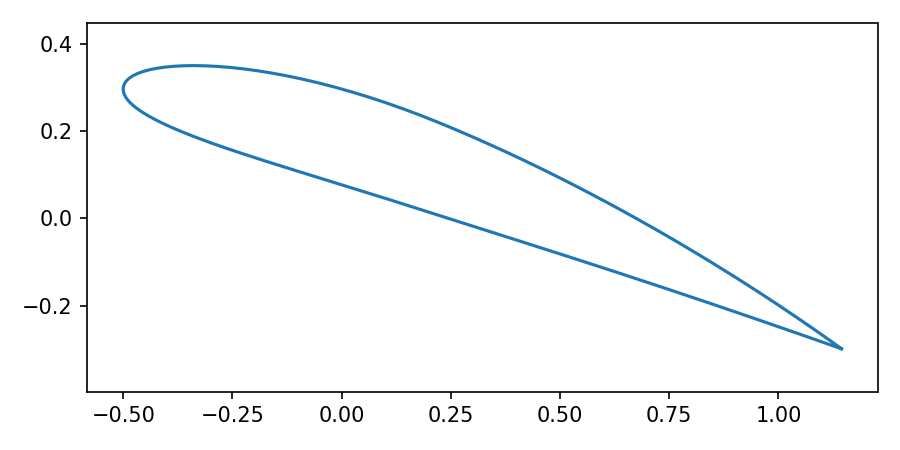

In [5]:


vertices = getAerofoil('4412', n = 64, rotation = -20, offset = [-0.5, .3], scaling = 1.75)
# vertices = vertices.tolist()

fig, axis = plt.subplots(1,1, figsize=(6,3), sharex = True, sharey = False, squeeze = False)
axis[0,0].plot(vertices[:,0],vertices[:,1])
axis[0,0].axis('equal')

fig.tight_layout()

In [6]:
x = np.linspace(-np.pi, np.pi, 16, endpoint=False)
y = np.sin(x) * 0.25
x = np.cos(x) * 0.25
vertices = np.vstack((x,y)).T

In [13]:
from src.solidBC import *

def nonperiodicBoundaryImpactConfig(radius = 0.014807730670234377, dt = 0.002, c = 0.25, device = 'cpu', precision = torch.float64):
    config = {
        'radius': radius,
        'omega':0.5,
        'targetNeighbors': 20,
        'restDensity': 1000,
        'dt':dt,
        'kappa':1.5,
        'viscosityConstant':0.01,
        'boundaryViscosityConstant':0.01,
        'max_neighbors':256,
        'device':device,
    #     'device':device,
        'precision': precision,
        'domain':{
            'periodicX':True,
            'periodicY':True,
            'min': [-2, -1],
            'max': [6,1],
            'buffer': 2
        },
        'dfsph':{
            'minDensitySolverIterations': 2,
            'maxDensitySolverIterations': 256,
            'minDivergenceSolverIterations': 2,
            'maxDivergenceSolverIterations': 8,
            'densityThreshold': 1e-4,
            'divergenceSolver': True,
            'divergenceThreshold': 1e-2,
            'backgroundPressure':True
        },
        'gravity': [0,0]
        ,
        'solidBoundary':[
            {
                'vertices': [[-0.35,-0.35],[0.35,-0.35],[0.35,0.35],[-0.35,0.35]],
                'inverted': False
            }
        ],
        'export':{
            'active': False,
            'prefix': 'fpc'
        }
    }
    theta = np.linspace(0,2*np.pi, 16, endpoint = False)
    coords = np.vstack((np.cos(theta), np.sin(theta))).T * c
#     config['solidBoundary'][0]['vertices'] = coords.tolist()
    config['solidBoundary'][0]['vertices'] = vertices
    
    config['maxValue'] = torch.finfo(config['precision']).max

    config['area'] = np.pi * config['radius']**2
    config['support'] = np.single(np.sqrt(config['area'] / np.pi * config['targetNeighbors']))
    
    debugPrint(config['support'])


    config['packing'] = minimize(lambda x: evalPacking(x,config), 0.5, method="nelder-mead").x[0]
    config['spacing'] = -minimize(lambda x: evalSpacing(x,config), 0., method="nelder-mead").x[0]
    
    D = (config['domain']['max'][1] - config['domain']['min'][1])
    spacing = config['spacing']
    packing = config['packing']
    n = int(np.ceil((D / config['support'] - 2 * spacing)/packing))
    h = D / (2 * spacing + n * packing)
    area = h**2 / config['targetNeighbors'] * np.pi
    radius = np.sqrt(area / np.pi)
#     print(D, spacing, packing, n, h, area, radius)
    
    config['radius'] = radius
    config['area'] = area
    config['support'] = h
    
    config['spacingContribution'] = evalContrib(config['spacing'], config)
    
    
    p = config['packing'] * config['support']
    # print(config['packing'])

    minDomain = config['domain']['min']
    maxDomain = config['domain']['max']
    
    config['velocitySources'] = [
            {'min' : [minDomain[0], minDomain[1]],
             'max' : [minDomain[0] + 4 * config['support'],maxDomain[1]],
             'rampTime' : 1,
             'velocity' : [2.5,0]},
            {'min' : [maxDomain[0] - 4 * config['support'], minDomain[1]],
             'max' : [maxDomain[0] ,maxDomain[1]],
             'rampTime' : 1,
             'velocity' : [2.5,0]}
            
        ]

    spacing = (config['spacing'] * config['support'])
    
    nx = int(np.ceil((config['domain']['max'][0] - config['domain']['min'][0]) / p))
    ny = int(np.ceil((config['domain']['max'][1] - config['domain']['min'][1]) / p))
#     print('nx', nx)
#     print('prior', config['domain']['max'][0])
    config['domain']['max'][0] = config['domain']['min'][0] + nx * p
    config['domain']['max'][1] = config['domain']['min'][1] + ny * p
#     print('after', config['domain']['max'][0])

    minDomain = config['domain']['min']
    maxDomain = config['domain']['max']
    
    config['emitters'] = [
        {
#         'min': np.array([minDomain[0] + p / 2, minDomain[1] + spacing]),
#         'max': np.array([maxDomain[0] - p / 2, maxDomain[1] - spacing]),
        'min': np.array([minDomain[0] + spacing, minDomain[1] + p/2]),
        'max': np.array([maxDomain[0] - p / 2, maxDomain[1] - p/2]),
        'velocity': [0,0]
        ,'compression': 1.00
    }
    ]


    for emitter in config['emitters']:
        if 'radius' not in emitter:
            emitter['radius'] = config['radius']
        if 'density' not in emitter:
            emitter['density'] = config['restDensity']
        if 'type' not in emitter:
            emitter['type'] = 'once'
        if 'compression' not in emitter:
            emitter['compression'] = 1.0
        if 'velocity' not in emitter:
            emitter['velocity'] = [0.0,0.0]
    if 'gravity' not in config:
        config['gravity'] = [0,0]


    minCompression = config['maxValue']
    for emitter in config['emitters']:
        minCompression = min(minCompression, emitter['compression'])
    config['minCompression'] = minCompression

#     adjustDomainForEmitters(config, fixSizes = False)
#     config['domain']['min'][1] = config['domain']['min'][1]
#     config['domain']['max'][1] = config['domain']['max'][1]


    config['domain']['virtualMin'] = config['domain']['min']
    config['domain']['virtualMax'] = config['domain']['max']
    config['domain']['min'] = config['domain']['min'] - config['domain']['buffer'] * config['support']
    config['domain']['max'] = config['domain']['max'] + config['domain']['buffer'] * config['support']
    
    
    
    addBoundaryBoundaries(config)
    if 'solidBoundary' in config:
        for boundary in config['solidBoundary']:
            boundary['polygon'] = torch.tensor(boundary['vertices'], device = config['device'], dtype = config['precision'])
        
#     print(config['solidBoundary'])
    return config

In [14]:
config = nonperiodicBoundaryImpactConfig(radius = 0.014426521330548324, c = 0.125, dt = 0.002, device= 'cuda', precision = torch.float32)

config['support'] [float32] = 0.06451736390590668


In [15]:
import copy

In [16]:
# def optimizeInitialParticles(config, state, stepFn, simFn, optimDt = 1e-5):    
#     oldDt = config['dt']
#     oldSource = config.pop('velocitySources', None)
#     oldViscosityConstant = config['viscosityConstant']
    
#     config['dt'] = optimDt
#     config['viscosityConstant'] = 0.1    
#     stepFn(1)
#     t = trange(2048)
#     print('Rough initial optimization')
#     for i in t:
#     #     t.set
#         simFn(config, state)
#         state['fluidVelocity'] *= 0.95
#         if i % 16 == 0:
#             stepFn(1)
#             state['fluidVelocity'] *= 0.95
#     #     stepFn(1)
#     #     print(torch.mean(state['fluidVelocity']))
#         t.set_postfix_str('iterations: %3d, velocity: %1.4e' %(len(state['densityIterations']), torch.mean(state['fluidVelocity'])))
#         if len(state['densityIterations']) < 10 and i > 128:
#             break
#     print('Refining initial optimization with small dt')
#     t = trange(2048)
#     for i in t:
#         simFn(config, state)
#         state['fluidVelocity'] *= 0.95
#         if i % 16 == 0:
#             stepFn(1)
#             state['fluidVelocity'] *= 0.95
#         t.set_postfix_str('iterations: %3d, velocity: %1.4e' %(len(state['densityIterations']), torch.mean(state['fluidVelocity'])))
#     #     stepFn(1)
#         if len(state['densityIterations']) < 10 and i > 256:
#             break

#     stepFn(1)
#     print('Second stage optimization')
#     config['dt'] = 0.002
#     dampening = 0.95
#     t = trange(2048)
#     for i in t:
#         simFn(config, state)
#         state['fluidVelocity'] *= 0.95
#         if i % 16 == 0:
#             stepFn(1)
#             state['fluidVelocity'] *= 0.95
#         t.set_postfix_str('iterations: %3d, velocity: %1.4e' %(len(state['densityIterations']), torch.mean(state['fluidVelocity'])))
#         if len(state['densityIterations']) < 10 and i > 512:
#             break

#     stepFn(1)

#     state['time'] *= 0
#     state['timestep'] *= 0
#     config['dt'] = oldDt
#     if oldSource != None:
#         config['velocitySources'] = oldSource
        
#     config['viscosityConstant']=oldViscosityConstant

<IPython.core.display.Javascript object>


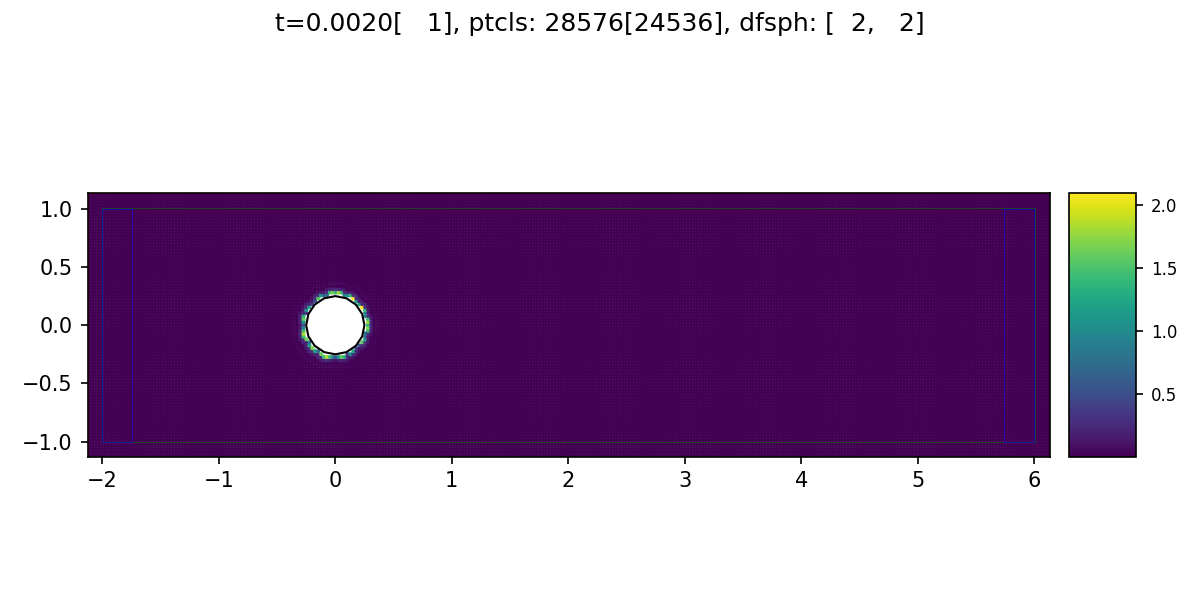

In [17]:

import torch.autograd.profiler as profiler
from src.kernel import *
from src.neighborhood import *
from src.periodicBC import *
from src.solidBC import *
from src.sph import *

def getVelocityXY(config, simulationState, nx = 256, ny = 256):
    xx,yy,uv = getUVs(simulationState['fluidVelocity'], config, simulationState, nx,ny)
    data = np.linalg.norm(uv,axis=2)
    return data[::-1,:]
def getVelocityScatter(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        np.linalg.norm(simulationState['fluidVelocity'].detach().cpu().numpy(), axis = 1)

def getDensityXY(config, simulationState, nx = 256, ny = 256):
    xx,yy,uv = getUVs(simulationState['fluidDensity'], config, simulationState, nx,ny)
    return uv
def getDensityScatter(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        simulationState['fluidDensity'].detach().cpu().numpy()

xyPlotFn = lambda config, state, nx, ny: getVelocityXY(config, state, nx = 256, ny = 256)
scatterPlotFn = lambda config, state: getVelocityScatter(config, state)

# with profiler.profile(with_stack=True, profile_memory=True) as prof:  
boundaryPressureForces = []
boundaryFrictionForces = []
timeValues = []
dampening = 0.95
def simFn(config, state):
    global boundaryPressureForces, boundaryFrictionForces,dampening
    incompressibleSimulation(config, state)
    boundaryPressureForces.append(state['boundaryPressureForce'].detach().cpu().numpy())
    boundaryFrictionForces.append(state['boundaryFrictionForce'].detach().cpu().numpy())
    timeValues.append(state['time'])
    
    
# simFn = lambda config, state: 

state, stepFn = setupSimulation(config, simFn, scatterPlotFn, 256, 256, saveFrames = True, figsize = (8,4))


xyPlotFn = lambda config, state, nx, ny: getVelocityXY(config, state, nx = 256, ny = 256)

<IPython.core.display.Javascript object>


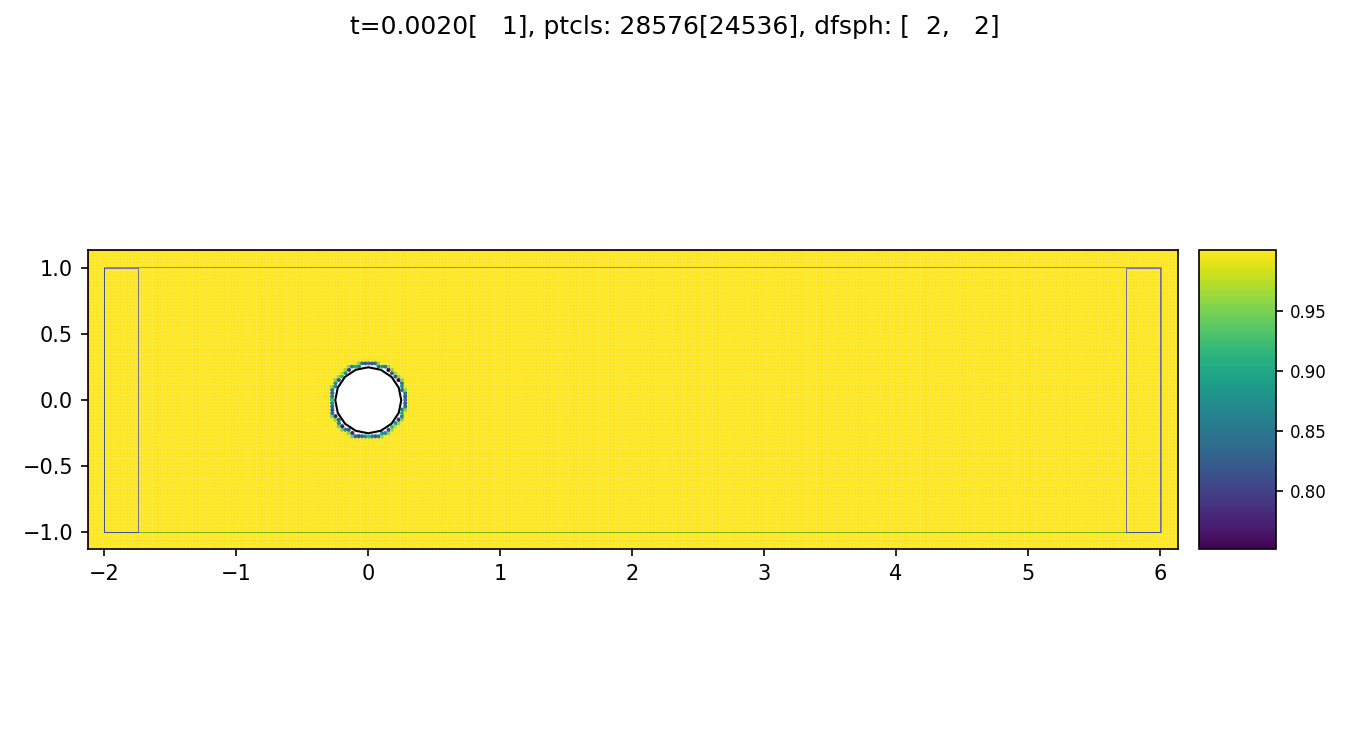

In [18]:
fig, im, axis, cbar = initialPlot(config, state, \
                                  [getDensityScatter], \
                                  256, 256, figsize=(9,5))

In [13]:
def shiftNTimes(n, config, state):
    for i in range(n):
        state['fluidNeighbors'], state['fluidDistances'], state['fluidRadialDistances'] = \
            neighborSearch(state['fluidPosition'], state['fluidPosition'], config, state)

        state['boundaryNeighbors'], state['boundaryDistances'], state['boundaryGradients'], \
            state['boundaryIntegrals'], state['boundaryIntegralGradients'], \
            state['boundaryFluidNeighbors'], state['boundaryFluidPositions'] = boundaryNeighborSearch(config, state)

        state['fluidDensity'] = sphDensity(config, state)  
        solveShifting(config, state)
        state['fluidPosition'] += state['fluidUpdate']

        enforcePeriodicBC(config, state)
shiftNTimes(256, config, state)
#     def getUpdateScatterY(config, simulationState):
#         return simulationState['fluidPosition'].detach().cpu().numpy(), \
#             torch.linalg.norm(simulationState['fluidUpdate'], axis = 1).detach().cpu().numpy()

updatePlot(config, state, fig, axis, im, cbar, [getDensityScatter], 256, 256)

In [14]:
# optimizeInitialParticles(config, state, stepFn, simFn, optimDt = 1e-5)

In [15]:
def getVelocityXY(config, simulationState, nx = 256, ny = 256):
    xx,yy,uv = getUVs(simulationState['fluidVelocity'], config, simulationState, nx,ny)
    data = np.linalg.norm(uv,axis=2)
    return data[::-1,:]
def getDensityXY(config, simulationState, nx = 256, ny = 256):
    xx,yy,uv = getUVs(simulationState['fluidDensity'], config, simulationState, nx,ny)
    return uv[::-1,:]
def getPressureXY(config, simulationState, nx = 256, ny = 256):
    xx,yy,uv = getUVs(simulationState['fluidPressure'], config, simulationState, nx,ny)
    return uv[::-1,:]

def getVelocityScatter(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        np.linalg.norm(simulationState['fluidVelocity'].detach().cpu().numpy(), axis = 1)
def getDensityScatter(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        simulationState['fluidDensity'].detach().cpu().numpy()
def getPressureScatter(config, simulationState):
    return simulationState['fluidPosition'].detach().cpu().numpy(), \
        simulationState['fluidPressure'].detach().cpu().numpy()

xyPlotFnVelocity = lambda config, state, nx, ny: getVelocityXY(config, state, nx = 256, ny = 256)
xyPlotFnDensity = lambda config, state, nx, ny: getDensityXY(config, state, nx = 256, ny = 256)
xyPlotFnPressure = lambda config, state, nx, ny: getPressureXY(config, state, nx = 256, ny = 256)

<IPython.core.display.Javascript object>


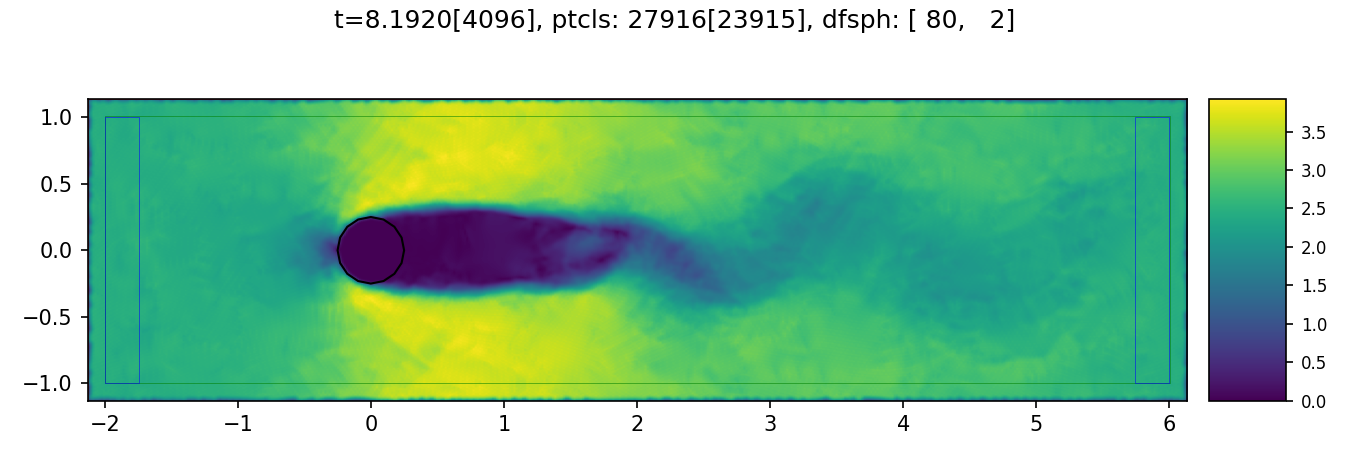

In [16]:
fig, im, axis, cbar = initialPlot(config, state, \
                                  [getVelocityXY], \
                                  512, 256, figsize=(9,3))

In [17]:
from incompressible import *

In [18]:
boundaryPressureForces = []
boundaryFrictionForces = []
timeValues = []



def simFn(config, state):
    global boundaryPressureForces, boundaryFrictionForces
    
    incompressibleSimulation(config, state)
    shiftNTimes(2, config, state)
    if config['export']['active']:
        state['outGroup'].create_dataset('positionAfterShift', data=state['fluidPosition'].detach().cpu().numpy())

    boundaryPressureForces.append(state['boundaryPressureForce'].detach().cpu().numpy())
    boundaryFrictionForces.append(state['boundaryFrictionForce'].detach().cpu().numpy())
    timeValues.append(state['time'])
    
# timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# state['path'] = './output/%s/' %timestamp
# if not os.path.exists(state['path']):
#     os.makedirs(state['path'])

for i in tqdm(range(4096)):
    simFn(config, state)
    if i%2 == 0:
        updatePlot(config, state, fig, axis, im, cbar, [getVelocityXY], 512, 256)
#     updatePlot(config, state, fig, axis, im, cbar, xyPlotFn, 256, 256)
#         imagePath = state['path'] + '%05d.png' % state['timestep']
#         plt.savefig(imagePath)


  0%|          | 0/4096 [00:00<?, ?it/s]

In [20]:
state['outFile'].close()

In [19]:
dragForces = np.array(boundaryFrictionForces)
pressureForces = np.array(boundaryPressureForces)
times = np.array(timeValues)
dragForces = dragForces.reshape(times.shape[0],2)
pressureForces = pressureForces.reshape(times.shape[0],2)

In [20]:
mask = times > 2.

dragForces = dragForces[mask]
pressureForces = pressureForces[mask]
times = times[mask]

In [21]:
height = np.max(np.array(vertices)[:,1]) - np.min(np.array(vertices)[:,1])
print(height)
# height = 0.7

0.5


In [22]:
dragForces[:,0] = 2 * dragForces[:,0] / 1000 / (2.5**2) * height
pressureForces[:,0] = 2 * pressureForces[:,0] / 1000 / (2.5**2) * height

dragForces[:,1] = 2 * dragForces[:,1] / 1000 / (2.5**2) * height
pressureForces[:,1] = 2 * pressureForces[:,1] / 1000 / (2.5**2) * height

<IPython.core.display.Javascript object>


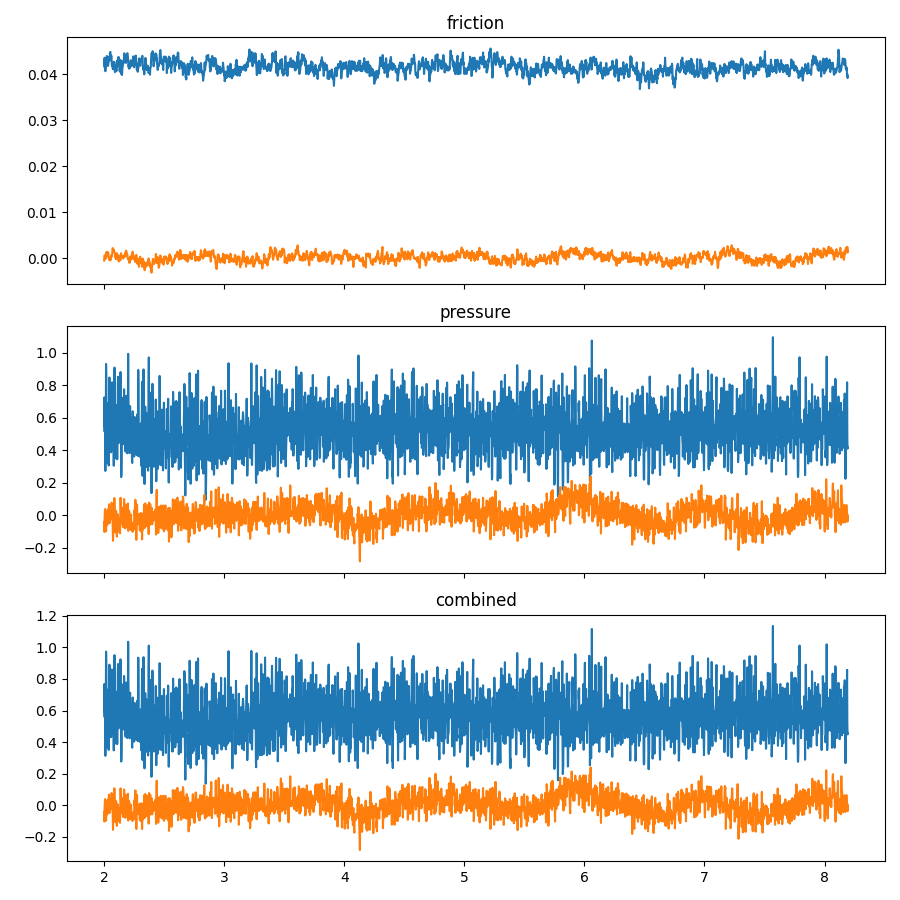

In [23]:
fig, axis = plt.subplots(3,1, figsize=(9,9), sharex = True, sharey = False, squeeze = False)

axis[0,0].set_title('friction')
axis[0,0].plot(times, dragForces[:,0], label = 'friction')
axis[0,0].plot(times, dragForces[:,1], label = 'friction')
# axis[0,0].plot(times, pressureForces[:,0], label = 'pressure')
# axis[0,0].plot(times, dragForces[:,0] + pressureForces[:,0], label = 'total')
# axis[0,0].legend()

axis[1,0].set_title('pressure')
axis[1,0].plot(times, pressureForces[:,0], label = 'pressure')
axis[1,0].plot(times, pressureForces[:,1], label = 'pressure')
# axis[1,0].plot(times, dragForces[:,1] , label = 'friction')
# axis[1,0].plot(times, pressureForces[:,1], label = 'pressure')
# axis[1,0].plot(times, dragForces[:,1] + pressureForces[:,1], label = 'total')
# axis[1,0].legend()

axis[2,0].set_title('combined')
axis[2,0].plot(times, pressureForces[:,0] + dragForces[:,0], label = 'pressure')
axis[2,0].plot(times, pressureForces[:,1] + dragForces[:,1], label = 'pressure')
# axis[2,0].plot(times, np.linalg.norm(dragForces, axis = 1), label = 'friction')
# axis[2,0].plot(times, np.linalg.norm(pressureForces, axis = 1), label = 'pressure')
# axis[2,0].plot(times, np.linalg.norm(dragForces + pressureForces, axis = 1), label = 'total')
# axis[2,0].legend()

fig.tight_layout()

In [24]:
print(np.mean(pressureForces[:,0]))
print(np.mean(dragForces[:,0]))
print(np.mean(pressureForces[:,0] + dragForces[:,0]))

0.524652
0.041589234
0.5662412


In [97]:
print(np.mean(pressureForces[:,1]))
print(np.mean(dragForces[:,1]))
print(np.mean(pressureForces[:,1] + dragForces[:,1]))

-0.00038609045
4.8077395e-06
-0.00038128244


In [39]:
def sdPolyDer(poly, p, config, masked = False, inverted = False):     
    dh = 1e-4
    dpx = torch.zeros(p.shape, device = config['device'], dtype=config['precision'])
    dnx = torch.zeros(p.shape, device = config['device'], dtype=config['precision'])
    dpy = torch.zeros(p.shape, device = config['device'], dtype=config['precision'])
    dny = torch.zeros(p.shape, device = config['device'], dtype=config['precision'])
    
    dpx[:,0] += dh
    dnx[:,0] -= dh
    dpy[:,1] += dh
    dny[:,1] -= dh
    
    c = sdPoly(poly, p, config)
    cpx = sdPoly(poly, p + dpx, config)
    cnx = sdPoly(poly, p + dnx, config)
    cpy = sdPoly(poly, p + dpy, config)
    cny = sdPoly(poly, p + dny, config)

    if inverted:
        c = -c
        cpx = -cpx
        cnx = -cnx
        cpy = -cpy
        cny = -cny

    grad = torch.zeros(p.shape, device = config['device'], dtype=config['precision'])
    grad[:,0] = (cpx - cnx) / (2 * dh)
    grad[:,1] = (cpy - cny) / (2 * dh)
    
    gradLen = torch.linalg.norm(grad, axis =1)
    grad[torch.abs(gradLen) > 1e-5] /= gradLen[torch.abs(gradLen)>1e-5,None]
    
    return c, grad, gradLen

In [93]:
for ib, b in enumerate(config['solidBoundary']):
    i = state['fluidNeighbors'][1]
    j = state['fluidNeighbors'][0]
    
    polyDist, polyDer, polyDerLen = sdPolyDer(b['polygon'], state['fluidPosition'], config, inverted = b['inverted'])
    cp = state['fluidPosition'] - polyDist[:,None] * polyDer
    d = torch.einsum('nd,nd->n', polyDer, cp)
    neighDistances = torch.einsum('nd,nd->n', state['fluidPosition'][j], polyDer[i]) - d[i]
    
    i = i[neighDistances >= 0]
    j = j[neighDistances >= 0]
    
    state['fluidNeighbors'] = torch.vstack((j,i))

In [94]:
neighDistances[neighDistances<0]

tensor([], device='cuda:0')

In [87]:
print(state['fluidNeighbors'])

tensor([[    0,     0,     0,  ..., 14501, 14501, 14501],
        [    0,     1,     2,  ..., 14497, 14498, 14501]], device='cuda:0')


In [88]:
state['fluidNeighbors'], state['fluidDistances'], state['fluidRadialDistances'] = \
            neighborSearch(state['fluidPosition'], state['fluidPosition'], config, state)

In [90]:
print(state['fluidNeighbors'])

tensor([[    0,     0,     0,  ..., 14501, 14501, 14501],
        [    0,     1,     2,  ..., 14497, 14498, 14501]], device='cuda:0')
